# CSC413 Lab 5: Transfer Learning and Descent

Transfer learning is a technique where we use neural network weights trained
to complete one task to complet a different task.
In this tutorial, we will go through an example of *transfer learning* to
detect American Sign Language (ASL) gestures letters A-I.
Although we could train a CNN from scratch,
you will see that using CNN weights that are pretrained on a larger dataset and
more complex task provides much better results, all with less training.

American Sign Language (ASL) is a complete, complex language that employs signs made by
moving the hands combined with facial expressions and postures of the body.
It is the primary language of many North Americans who are deaf and is one of several
communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabets are shown below. This lab focuses on
classifying a subset of these hand gesture images using convolutional neural networks.
Specifically, given an image of a hand showing one of the letters A-I, we want to detect
which letter is being represented.

![Image](https://www.lifeprint.com/asl101/fingerspelling/images/abc1280x960.png)

By the end of this lab, you will be able to:

1. Analyze the role of batch normalization and other model architecture choice in a neural network.
2. Define the double descent phenomenon and explain why it occurs.
3. Analyze the shape of the training curve of a convolutional neural network with respect to the double descent phenomenon.
4. Apply transfer learning to solve an image classification task.
5. Compare transfer learning vs. training a CNN from scratch.
6. Identify and suggest corrections for model building issues by inspecting misclassified data.


Acknowledgements:

- Data is collected from a previous machine learning course APS360. Only data
  of students who provided consent is included.

Please work in groups of 1-2 during the lab.

## Submission

If you are working with a partner, start by creating a group on Markus.
If you are working alone,
click "Working Alone".

Submit the generated PDF file `lab05.pdf` on Markus
**containing all your solutions to the Graded Task**s.
Your file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

- Part 1. Your answer to the question about the splitting of the data into train/validation/test sets. (1 point)
- Part 2. Your comparison of the CNN model with and without batch normalization. (1 point)
- Part 2. Your comparison of `BatchNorm1d` vs `BatchNorm2d`.  (1 point)
- Part 2. Your analysis of the effect of varying the CNN model width. (1 point)
- Part 2. Your analysis of the effect of varying weight decay parameter. (1 point)
- Part 2. Your analysis of the training curve that illustrates double descent. (1 point)
- Part 3. Your implementation of `LinearModel` for transfer learning. (1 point)
- Part 3. Your comparison of transfer learning vs the CNN model. (1 point)
- Part 4. Your analysis of the confusion matrix. (1 point)
- Part 4. Your explanation for how to mitigate an issue we notice by visually inspecting misclassified images. (1 point)

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets

%matplotlib inline

## Part 1. Data

We will begin by downloading the data onto Google Colab.

In [ ]:
# Download lab data file
!wget https://www.cs.toronto.edu/~lczhang/413/asl_data.zip
!unzip asl_data.zip

--2024-03-15 21:50:28--  https://www.cs.toronto.edu/~lczhang/413/asl_data.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5750695 (5.5M) [application/zip]
Saving to: ‘asl_data.zip’

asl_data.zip        100%[===================>]   5.48M  3.83MB/s    in 1.4s    

2024-03-15 21:50:30 (3.83 MB/s) - ‘asl_data.zip’ saved [5750695/5750695]

Archive:  asl_data.zip
   creating: asl_data/
   creating: asl_data/valid/
   creating: asl_data/test/
   creating: asl_data/train/
   creating: asl_data/valid/I/
   creating: asl_data/valid/G/
   creating: asl_data/valid/A/
   creating: asl_data/valid/F/
   creating: asl_data/valid/H/
   creating: asl_data/valid/C/
   creating: asl_data/valid/D/
   creating: asl_data/valid/E/
   creating: asl_data/valid/B/
   creating: asl_data/test/I/
   creating: asl_data/test/G/
   creating: asl_data/test/A/

The file structure we use is intentional,
so that we can use `torchvision.datasets.ImageFolder`
to help load our data and create labels.

You can read what `torchvision.datasets.ImageFolder` does for us here
https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder

In [ ]:
train_path = "asl_data/train/" # edit me
valid_path = "asl_data/valid/" # edit me
test_path = "asl_data/test/"   # edit me

train_data = torchvision.datasets.ImageFolder(train_path, transform=torchvision.transforms.ToTensor())
valid_data = torchvision.datasets.ImageFolder(valid_path, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.ImageFolder(test_path, transform=torchvision.transforms.ToTensor())

As in previous labs, we can iterate through the dataset one training data point at a time like this:

tensor([[[0.6706, 0.6549, 0.6275,  ..., 0.6706, 0.6706, 0.6706],
         [0.6706, 0.6549, 0.6314,  ..., 0.6706, 0.6706, 0.6706],
         [0.6706, 0.6549, 0.6314,  ..., 0.6706, 0.6706, 0.6706],
         ...,
         [0.5647, 0.5765, 0.5137,  ..., 0.8902, 0.8902, 0.8902],
         [0.5569, 0.5765, 0.5176,  ..., 0.8902, 0.8902, 0.8902],
         [0.5569, 0.5765, 0.5176,  ..., 0.8902, 0.8902, 0.8902]],

        [[0.6588, 0.6431, 0.6157,  ..., 0.6588, 0.6588, 0.6588],
         [0.6588, 0.6431, 0.6196,  ..., 0.6588, 0.6588, 0.6588],
         [0.6588, 0.6431, 0.6196,  ..., 0.6588, 0.6588, 0.6588],
         ...,
         [0.5725, 0.5843, 0.5176,  ..., 0.8902, 0.8902, 0.8902],
         [0.5647, 0.5843, 0.5216,  ..., 0.8902, 0.8902, 0.8902],
         [0.5647, 0.5843, 0.5216,  ..., 0.8902, 0.8902, 0.8902]],

        [[0.6392, 0.6235, 0.5961,  ..., 0.6314, 0.6314, 0.6314],
         [0.6392, 0.6235, 0.6000,  ..., 0.6314, 0.6314, 0.6314],
         [0.6392, 0.6235, 0.6000,  ..., 0.6314, 0.6314, 0.

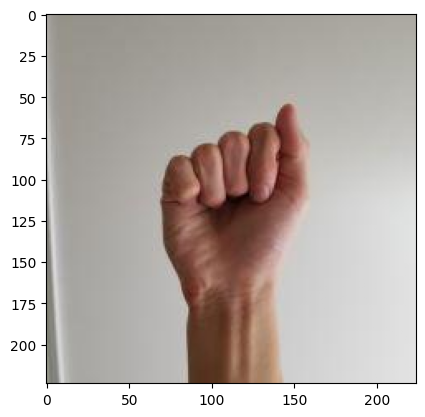

In [ ]:
for x, t in train_data:
    print(x, t)
    plt.imshow(x.transpose(2, 0).transpose(0, 1).numpy()) # display an image
    break # uncomment if you'd like

**Task**: What do the variables `x` and `t` contain? What is the shape of our images?
What are our labels? Based on what you learned in Part (a), how were the
labels generated from the folder structure?

In [ ]:
# x contains RGB values for the image, while t contains the letter or number the
# hand sign represents. The shape of the image is 224x224.

We saw in the earlier tutorials that PyTorch has a utility to help us
creat minibatches with our data. We can use the same DataLoader helper
here:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

for x, t in train_loader:
    print(x, t)
    break # uncomment if you'd like

tensor([[[[0.8431, 0.8431, 0.8431,  ..., 0.8157, 0.8157, 0.8157],
          [0.8431, 0.8431, 0.8431,  ..., 0.8157, 0.8157, 0.8157],
          [0.8431, 0.8431, 0.8431,  ..., 0.8157, 0.8157, 0.8157],
          ...,
          [0.8471, 0.8471, 0.8471,  ..., 0.8078, 0.8078, 0.8078],
          [0.8471, 0.8471, 0.8471,  ..., 0.8078, 0.8078, 0.8078],
          [0.8471, 0.8471, 0.8471,  ..., 0.8078, 0.8078, 0.8078]],

         [[0.8392, 0.8392, 0.8392,  ..., 0.8118, 0.8118, 0.8118],
          [0.8392, 0.8392, 0.8392,  ..., 0.8118, 0.8118, 0.8118],
          [0.8392, 0.8392, 0.8392,  ..., 0.8118, 0.8118, 0.8118],
          ...,
          [0.8314, 0.8314, 0.8314,  ..., 0.8039, 0.8039, 0.8039],
          [0.8314, 0.8314, 0.8314,  ..., 0.8039, 0.8039, 0.8039],
          [0.8314, 0.8314, 0.8314,  ..., 0.8039, 0.8039, 0.8039]],

         [[0.8314, 0.8314, 0.8314,  ..., 0.8039, 0.8039, 0.8039],
          [0.8314, 0.8314, 0.8314,  ..., 0.8039, 0.8039, 0.8039],
          [0.8314, 0.8314, 0.8314,  ..., 0

**Task**: What do the variables `x` and `t` contain? What are their shapes?
What data do they contain?

In [ ]:
for x,t in train_loader:
  print(x.shape)
  print(t.shape)

# The shape of x is (10,3,244,244) as they contain a minibatch of 10 images with
# 3 244x244 matrices of numbers between 0 and 255 representing RGB. The shape of
# t is (10) as they represent the target symbol for each image, an A-I letter.

torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([7, 3, 224, 224])
torch.Size([7])


**Task**: How many images are there in the training, validation, and test sets?

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

# There are 207 training points, 733 validation points, and 223 test points.

207
733
223


Notice that there are *fewer* images in the training set, compared to the validation and test sets.
This is so that we can explore the effect of having a limited training set.

**Graded Task**: The data set is generated by students taking pictures of their hand
while making the corresponding gestures. We therefore split the
training, validation, and test sets were split so that images generated by
a student all belongs in a single data set. In other words, we avoid cases where
some students' images are in the training set and others end up in the test set.
Why do you think this is important for obtaining a representative test accuracy?

In [ ]:
# If we do not do this, the model would be skewed towards that one student, as
# it would overfit only to the way that student performs hand gestures primarily
# which would likely make it less accurate when attempting to classify other
# students' hand gestures unless they have really similar hands. That is, for
# any other student with a comparatively different hand shape and appearance, it
# would likely perform just as well as an untrained model.

## Part 2. Training a CNN Model

For this part, we will be working with this CNN network.

In [ ]:
class CNN(nn.Module):
    def __init__(self, width=4, bn=True):
        """
        A 4-layer convolutional neural network. The first layer has
        `width` number of channels, and with each layer we half the
        feature width/height and double the number of channels.

        If `bn` is set to False, then batch normalization will not run.
        """
        super(CNN, self).__init__()
        self.width = width
        self.bn = bn
        # define all the conv layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=self.width,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.width,
                               out_channels=self.width*2,
                               kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=self.width*2,
                               out_channels=self.width*4,
                               kernel_size=3,
                               padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.width*4,
                               out_channels=self.width*8,
                               kernel_size=3,
                               padding=1)
        # define all the BN layers
        if bn:
            self.bn1 = nn.BatchNorm2d(self.width)
            self.bn2 = nn.BatchNorm2d(self.width*2)
            self.bn3 = nn.BatchNorm2d(self.width*4)
            self.bn4 = nn.BatchNorm2d(self.width*8)
        # pooling layer has no parameter, so one such layer
        # can be shared across all conv layers
        self.pool = nn.MaxPool2d(2, 2)
        # FC layers
        self.fc1 = nn.Linear(self.width * 8 * 14 * 14, 100)
        self.fc2 = nn.Linear(100, 9)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        if self.bn:
            x = self.bn1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        if self.bn:
            x = self.bn2(x)
        x = self.pool(torch.relu(self.conv3(x)))
        if self.bn:
            x = self.bn3(x)
        x = self.pool(torch.relu(self.conv4(x)))
        if self.bn:
            x = self.bn4(x)
        x = x.view(-1, self.width * 8 * 14 * 14)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

**Task**: The training code is written for you. Train the `CNN()` model for at least 6 epochs, and report
on the maximum validation accuracy that you can attain.

As your model is training, you might want to move on to the next question.

In [ ]:
def get_accuracy(model, data, device="cpu"):
    loader = torch.utils.data.DataLoader(data, batch_size=256)
    model.to(device)
    model.eval() # annotate model for evaluation (important for batch normalization)
    correct = 0
    total = 0
    for imgs, labels in loader:
        labels = labels.to(device)
        output = model(imgs.to(device))
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_model(model,
                train_data,
                valid_data,
                batch_size=64,
                weight_decay=0.0,
                learning_rate=0.001,
                num_epochs=50,
                plot_every=20,
                plot=True,
                device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    model = model.to(device) # move model to GPU if applicable
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    # for plotting
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for epoch in range(num_epochs):
            for imgs, labels in iter(train_loader):
                if imgs.size()[0] < batch_size:
                    continue
                labels = labels.to(device)
                imgs = imgs.to(device)
                model.train()
                out = model(imgs)
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                iter_count += 1
                if iter_count % plot_every == 0:
                    loss = float(loss)
                    tacc = get_accuracy(model, train_data, device)
                    vacc = get_accuracy(model, valid_data, device)
                    print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (iter_count, loss, tacc, vacc))

                    iters.append(iter_count)
                    train_loss.append(loss)
                    train_acc.append(tacc)
                    val_acc.append(vacc)
    finally:
        plt.figure()
        plt.plot(iters[:len(train_loss)], train_loss)
        plt.title("Loss over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

        plt.figure()
        plt.plot(iters[:len(train_acc)], train_acc)
        plt.plot(iters[:len(val_acc)], val_acc)
        plt.title("Accuracy over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend(["Train", "Validation"])

**Task**: Run the training code below. What validation accuracy can be achieved by this CNN?

Iter 25; Loss 0.009797; Train Acc 0.464; Val Acc 0.307
Iter 50; Loss 0.001031; Train Acc 0.976; Val Acc 0.417
Iter 75; Loss 0.000640; Train Acc 1.000; Val Acc 0.476
Iter 100; Loss 0.000565; Train Acc 1.000; Val Acc 0.517
Iter 125; Loss 0.000296; Train Acc 1.000; Val Acc 0.533
Iter 150; Loss 0.000272; Train Acc 1.000; Val Acc 0.539


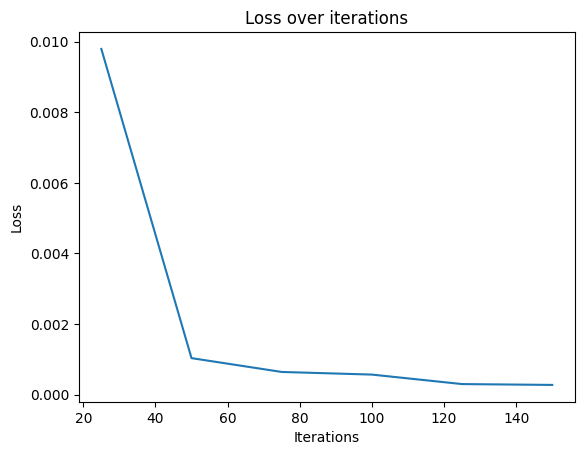

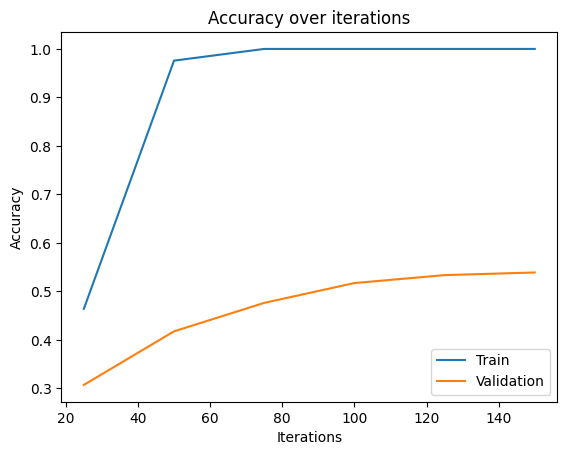

In [ ]:
cnn = CNN(width=4)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

# About 54% valid while almost 100% training.

## Part 2. Model Architecture, Bias/Variance and Double Descent

In this section, we will explore the effect of various aspects of
a CNN model architecture. We will pay particluar attention to
architecture decisions that affect the bias and variance of the
model. Finally, we explore a phenomenon called **double descent**.


To begin, let's explore the effect of batch normalization.

**Task**: Run the training code below to explore the effect of training *without* batch normalization.

Iter 25; Loss 1.920858; Train Acc 0.430; Val Acc 0.295
Iter 50; Loss 0.412757; Train Acc 0.879; Val Acc 0.508
Iter 75; Loss 0.146616; Train Acc 0.981; Val Acc 0.548
Iter 100; Loss 0.024245; Train Acc 0.995; Val Acc 0.559
Iter 125; Loss 0.005932; Train Acc 1.000; Val Acc 0.531
Iter 150; Loss 0.008437; Train Acc 1.000; Val Acc 0.542


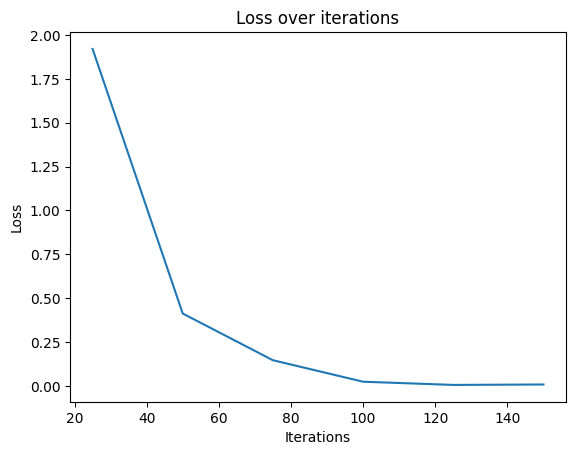

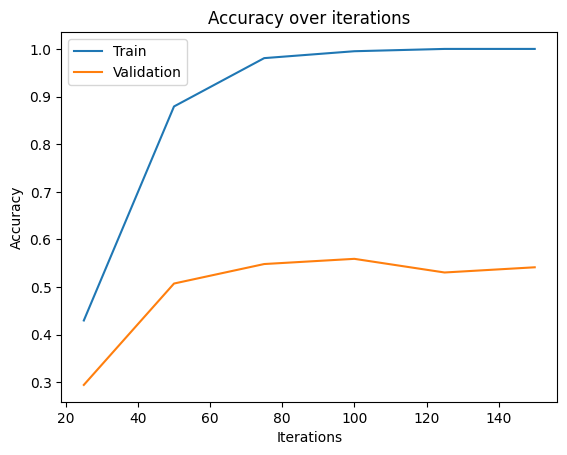

In [ ]:
cnn = CNN(bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

**Graded Task**: Compare the two sets of training curves above for the CNN model with and without
batch normalization. What is the effect of batch normalization on the training loss and accuracy?
What about the validation accuracy?

In [ ]:
# The loss curve in the batch normalization case is compressed to a much smaller
# magnitude, around 10^(-2), while the non-norm case has a loss that starts at
# 2 and goes down to something of this order only at the end. The convergence
# of the model to 100% accuracy also seems to be much faster in the batch norm
# case. However, the validation curves seem almost identical, in fact the non
# batch norm case seems to increase faster and ends at a higher value.

**Graded Task**:
We used the layer called `BatchNorm2d` in our CNN.
What do you think is the difference between `BatchNorm2d` and `BatchNorm1d`?
Why are we using `BatchNorm2d` in our CNN? Why would we use `BatchNorm1d` in an MLP?
You may wish to consult the PyTorch documentation. (How can you find it?)

In [ ]:
# BatchNorm2d is likely used for inputs that are two dimensional with a batch
# and channel dimension, that need to be normalized in a manner that reflects
# two dimensional geometric structure of the data, for example in images. On the
# other hand, while the 1d version is used for one dimensional inputs, such as
# regular classification models, or if we wish to flatten the images into a
# single dimension if we do not care about the actual relations between pixels
# beside each other.

**Task**: Run the training code below to explore the effect of varying the model width
for this particular data set.

Iter 25; Loss 2.188904; Train Acc 0.130; Val Acc 0.111
Iter 50; Loss 2.184609; Train Acc 0.130; Val Acc 0.111
Iter 75; Loss 1.985346; Train Acc 0.338; Val Acc 0.243
Iter 100; Loss 0.967371; Train Acc 0.787; Val Acc 0.472
Iter 125; Loss 0.435549; Train Acc 0.855; Val Acc 0.525
Iter 150; Loss 0.240832; Train Acc 0.947; Val Acc 0.503


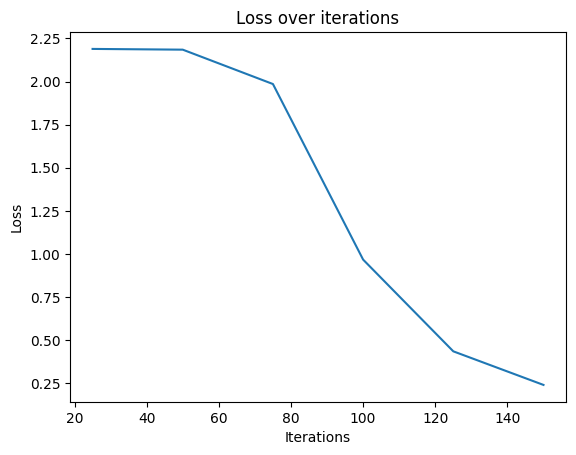

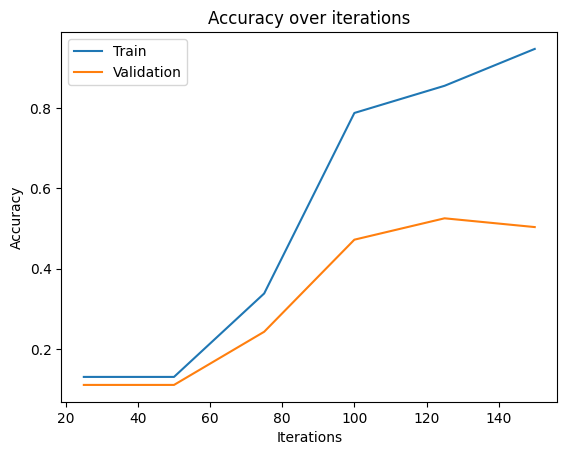

In [ ]:
cnn = CNN(width=2, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

Iter 25; Loss 2.150709; Train Acc 0.222; Val Acc 0.172
Iter 50; Loss 1.227389; Train Acc 0.700; Val Acc 0.407
Iter 75; Loss 0.433596; Train Acc 0.870; Val Acc 0.510
Iter 100; Loss 0.177997; Train Acc 0.937; Val Acc 0.506
Iter 125; Loss 0.060747; Train Acc 0.990; Val Acc 0.528
Iter 150; Loss 0.026884; Train Acc 1.000; Val Acc 0.524


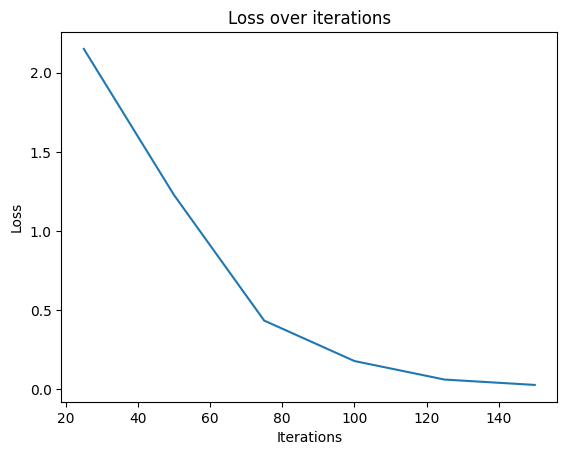

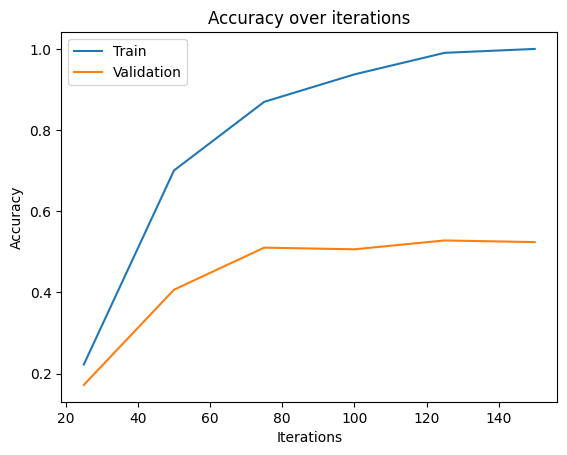

In [ ]:
cnn = CNN(width=4, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

Iter 25; Loss 2.042079; Train Acc 0.401; Val Acc 0.261
Iter 50; Loss 0.740498; Train Acc 0.754; Val Acc 0.486
Iter 75; Loss 0.174455; Train Acc 0.966; Val Acc 0.611
Iter 100; Loss 0.019485; Train Acc 1.000; Val Acc 0.607
Iter 125; Loss 0.004485; Train Acc 1.000; Val Acc 0.619
Iter 150; Loss 0.003236; Train Acc 1.000; Val Acc 0.610


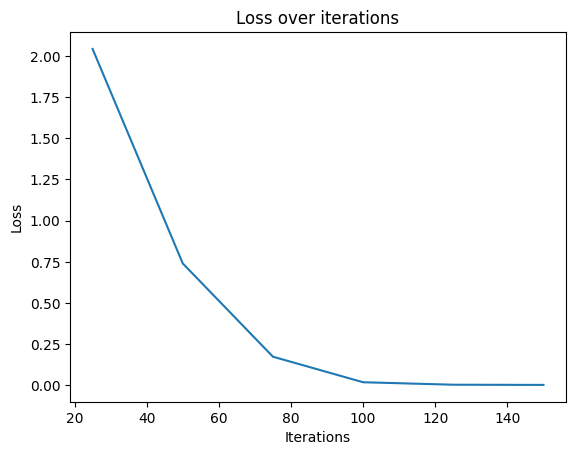

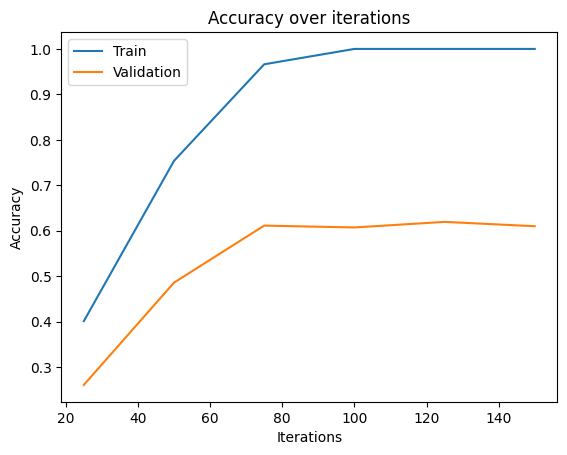

In [ ]:
cnn = CNN(width=16, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

**Graded Task**: What is the effect of varying the model width above for this particular data set?
Do you notice an effect on the training loss? What about the training/validation accuracy?
The final validation accuracy?
(Your answer may or may not match your expectations. Please answer based on the actual results above.)

In [ ]:
# Decreasing the model width slightly seems to slow down the convergence rate
# to full accuracy tremendously, as it does not even reach it, and the loss also
# does not go to the order 10^(-2) as in the regular width=4 case. However, the
# validation accuracy does not seem to be very different, suggesting that both
# models are likely similar in performance on new data. Note that this is likely
# because decreasing the channels to split into decreases the variability and
# hence predictivity of the model, so a model with more channels is likely to
# fit faster and more well to the training data. This is reflected in the last
# model with width=16, which reaches 100% training accuracy much faster, and
# even improves the validation accuracy to 61% due to the more predictive power
# and degrees of freedom it gets.

**Task**: Run the training code below to explore the effect of weight decay when training a large model.

Iter 25; Loss 1.652030; Train Acc 0.507; Val Acc 0.378
Iter 50; Loss 0.348323; Train Acc 0.874; Val Acc 0.557
Iter 75; Loss 0.097385; Train Acc 0.966; Val Acc 0.574
Iter 100; Loss 0.012845; Train Acc 1.000; Val Acc 0.577
Iter 125; Loss 0.001076; Train Acc 1.000; Val Acc 0.613
Iter 150; Loss 0.000644; Train Acc 1.000; Val Acc 0.602


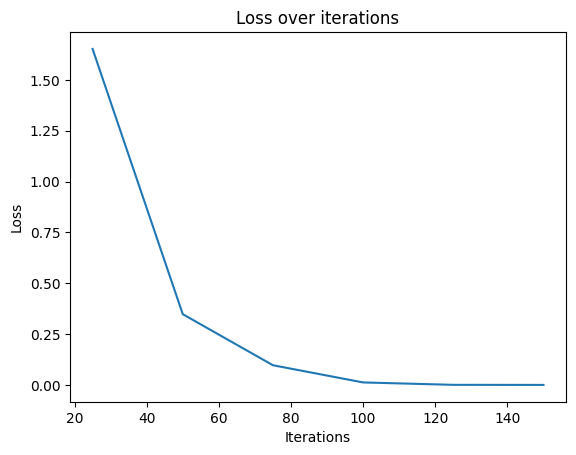

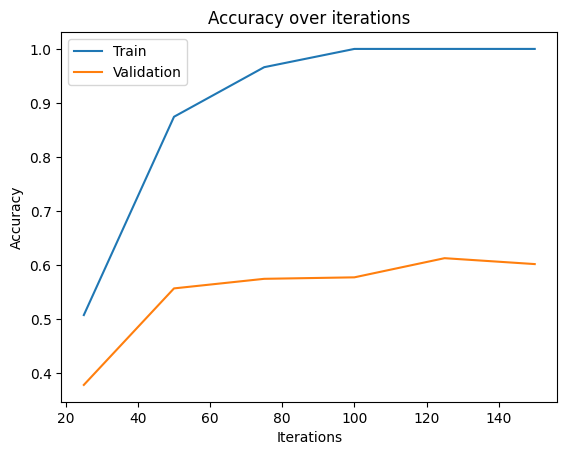

In [ ]:
cnn = CNN(width=16, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25, weight_decay=0.001)

Iter 25; Loss 0.021955; Train Acc 0.092; Val Acc 0.100
Iter 50; Loss 0.001626; Train Acc 0.778; Val Acc 0.422
Iter 75; Loss 0.000853; Train Acc 1.000; Val Acc 0.648
Iter 100; Loss 0.000578; Train Acc 1.000; Val Acc 0.633
Iter 125; Loss 0.000611; Train Acc 1.000; Val Acc 0.636
Iter 150; Loss 0.000554; Train Acc 1.000; Val Acc 0.637


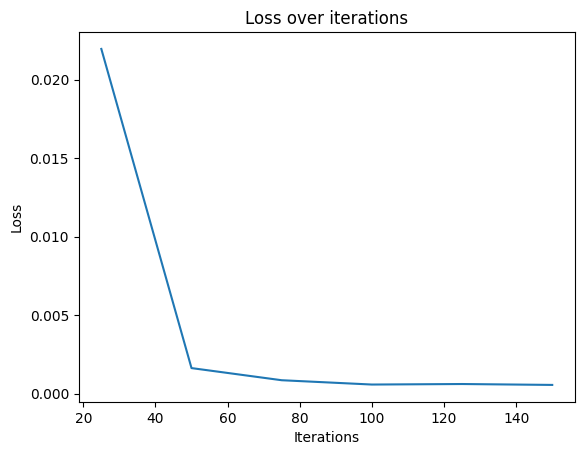

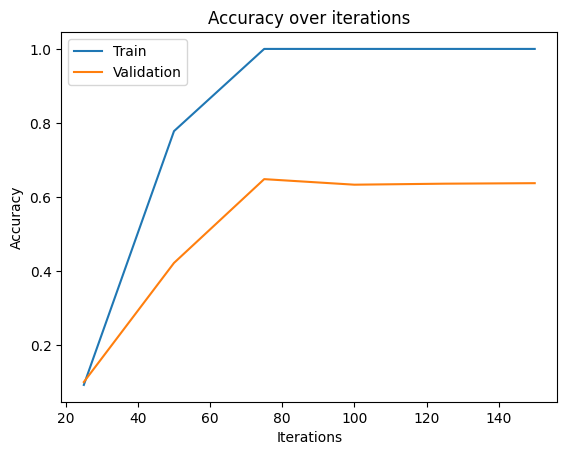

In [ ]:
cnn = CNN(width=16, bn=True) # try with batch norm on
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25, weight_decay=0.001)

Iter 25; Loss 0.010285; Train Acc 0.401; Val Acc 0.244
Iter 50; Loss 0.001050; Train Acc 0.932; Val Acc 0.543
Iter 75; Loss 0.000429; Train Acc 1.000; Val Acc 0.600
Iter 100; Loss 0.000373; Train Acc 1.000; Val Acc 0.614
Iter 125; Loss 0.000200; Train Acc 1.000; Val Acc 0.619
Iter 150; Loss 0.000191; Train Acc 1.000; Val Acc 0.622


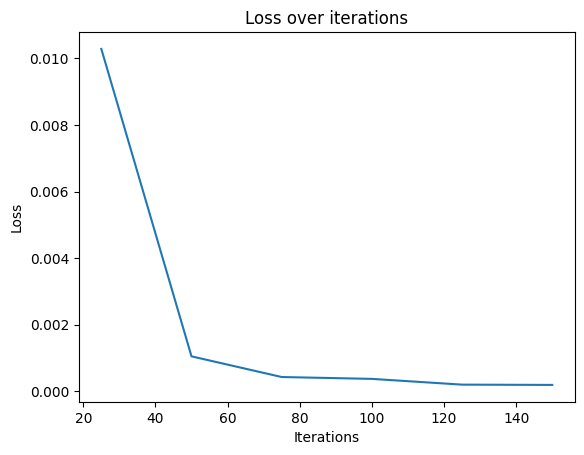

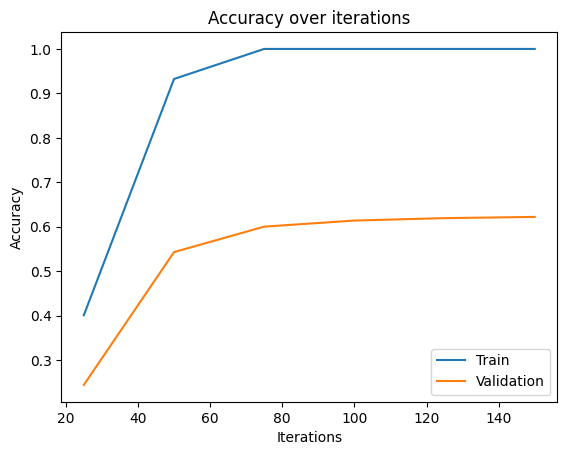

In [ ]:
cnn = CNN(width=16, bn=True) # try decreasing weight decay parameter
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25, weight_decay=0.0001)

**Graded Task**: What is the effect of setting weight decay to the above value?
Do you notice an effect on the training loss? What about the training/validation accuracy?
The final validation accuracy?
(Again, your answer may or may not match your expectations. Please answer based on the actual results above.)

In [ ]:
# With no batch norm, adding weight decay visibly increases the speed of the
# convergence, and also achieves a higher validation accuracy of 60%. With batch
# norm, this is even faster, and the validation accuracy is even higher at 64%.
# Even if the weight decay is reduced, it still performs relatively similar,
# with slightly faster convergence in training accuracy, though loss is larger,
# but the validation is slightly lower than before, which suggests weight decay
# is actually better when its of order 10^(-2) instead of 10^(-3).

**Task**: Note that there is quite a bit of noise in the results that we might obtain above.
That is, if you run the same code twice, you may obtain different answers.
Why might that be? What are two sources of noise/randomness?

In [ ]:
# The choice of batches is random, which could result in different training
# results in each model, as we are effectively randomly picking what to train
# on separately first (the same dilemma with SGD but with batches). The noise
# could intrinsically also come from the data, which is then increased by the
# fact that they are chosen to be grouped randomly into batches to be trained on
# in average gradients.

These settings that we have been exporting are hyperparameters that should
be tuned when you train a neural network. These hyperparameters interact with
one another, and thus we should tune them using the **grid search** strategy
mentioned in previous labs.

You are not required to perform grid search for this lab, so that we can
explore a few other phenomena.

One interesting phenomenon is called **double descent**. In statistical learning theory,
we expect validation error to *decrease* with increase model capacity, and then *increase*
as the model overfits to the number of data points available for training.
In practise, in neural networks, we often see that as model capacity increases,
validation error first decreases, then increase, and then **decrease again**---hence
the name "double descent".

In fact, the increase in validation error is actually quite subtle.
However, what is readily apparent is that in most cases, increasing
model capacity does *not* result in a decrease in validation accuracy.

**Optional Task**: To illustrate that validation accuracy is unlikely to decrease
with increased model parameter, train the below network.

In [ ]:
# Uncomment to run.
# cnn = CNN(width=40, bn=True)
# train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=50)

Double descent is actually not that mysterious. It comes from the fact that
when capacity is large enough there are many parameter choices that achieves 100% training accuracy,
the neural network optimization procedure is effectively choosing a *best parameters*
out of the many that can achieve this perfect training accuracy. This differs from
when capacity is low, where the optimization process needs to find a set of parameter choices that
best fits the training data---since no choice of parameters fits the training data perfectly.
When the capacity is just large enough to be able to find parameters that fit the data,
but too small for there be a range of parameter choices available to be able to select a "best" one.

This twitter thread written by biostatistics professor Daniela Witten
also provides an intuitive explanation, using polynomial curve fitting
as an example: [https://twitter.com/daniela_witten/status/1292293102103748609](https://twitter.com/daniela_witten/status/1292293102103748609)

Double descent explored in depth in this paper here:
[https://openreview.net/pdf?id=B1g5sA4twr](https://openreview.net/pdf?id=B1g5sA4twr)
This paper highlights that the increase in validation/test error occurs
when the training accuracy approximates 100%.
Moreover, the double descent phenomena is noticable when varying model capacity (e.g. number of parameters)
and when varying the number of iterations/epochs of training.

We will attempt to explore the latter effect---i.e. we will train a large model, use a small
number of training data points, and explore how each iteration of training impacts validation accuracy.
The effect is subtle and, depending on your neural network initialization, you may not see an effect.
An examplary training curve is also provided for you to analyze.

**Optional Task**: Run the code below to try and reproduce the "double descent" phenomena.
This code will take a while to run, so you may wish to continue with the remaining questions
while it runs.

In [ ]:
# use a subset of the training data
# uncomment to train

# train_data_subset, _ =  random_split(train_data, [50, len(train_data)-50])
# cnn = CNN(width=20)
# train_model(cnn,
#             train_data_subset,
#             valid_data,
#             batch_size=50, # set batch_size=len(train_data_subset) to minimize training noise
#             num_epochs=200,
#             plot_every=1,  # plot every epoch (this is slow)
#             learning_rate=0.0001)  # choose a low learning rate

For reference, here is the our training curve showing the loss and accuracy over 200 iterations:

<img src="https://www.cs.toronto.edu/~lczhang/413/double_descent_loss.png" width=400>
<img src="https://www.cs.toronto.edu/~lczhang/413/double_descent.png" width=400>

It might not be possible to consistently reproduce this result (e.g., due to initialization),
so it is totally reasonable for your figure to look different!


**Task**: In the provided training curve,
during which iterations does the validation accuracy initially increase
(i.e. validation error decrease)?

In [ ]:
# From about iteration 0 to 60 the validation accuracy increases due to the
# regular fitting process of descent.

**Graded Task**: In the provided training curve,
during which iterations do the validation accuracy decrease slightly?
Approximately what training accuracy is achieved at this piont?

In [ ]:
# From about iteration 60 to 90, the validation curve dips very slightly, which
# is achieved at around exactly where the training accuracy reaches 100%. This
# is the expected behaviour, as the overfitting occurs, but as more iterations
# pass, the model picks better parameters with the same 100% accuracy and gets
# the pre-dip validation accuracy again.

**Task**: In the provided training curve,
during which iterations do the validation accuracy increase for a second time
(i.e. validation error descends for a second time)?

In [ ]:
# From about iteration 100 to the end of the process (200), the validation acc.
# stops decreasing and although seemingly not moving, is likely increasing
# very slightly due to the double descent effect.

## Part 3. Transfer Learning

For many image classification tasks, it is generally not a good idea to train a
very large deep neural network model from scratch due to the enormous compute
requirements and lack of sufficient amounts of training data.

A better option is to try using an existing model that performs a
similar task to the one you need to solve. This method of utilizing a
pre-trained network for other similar tasks is broadly termed
**Transfer Learning**. In this assignment, we will use Transfer Learning
to extract features from the hand gesture images. Then, train a smaller
network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various
features from the images which get utilized by the fully connected layers
for correct classification. AlexNet architecture played a pivotal role in
establishing Deep Neural Nets as a go-to tool for image classification
problems and we will use an ImageNet pre-trained AlexNet model to
extract features in this assignment.

Here is the code to load the AlexNet network, with pretrained weights.
When you first run the code, PyTorch will download the pretrained weights
from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

print(alexnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 51.0MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

As you can see, the `alexnet` model is split up into two components:
`alexnet.features` and
`alexnet.classifier`.  The first neural network component, `alexnet.features`,
is used to
computed convolutional features, which is taken as input in `alexnet.classifier`.

The neural network `alexnet.features` expects an image tensor of shape
Nx3x224x224 as inputs and it will output a tensor of shape Nx256x6x6 . (N = batch size).

Here is an example code snippet showing how you can compute the AlexNet
features for some images (your actual code might be different):

In [ ]:
img, label = train_data[0]
features = alexnet.features(img.unsqueeze(0)).detach()

print(features.shape)

torch.Size([1, 256, 6, 6])


Note that the `.detach()` at the end will be necessary in your code. The reason is that
PyTorch automatically builds computation graphs to be able to backpropagate
graidents. If we did not explicitly "detach" this tensor from the AlexNet portion
of the computation graph, PyTorch might try to backpropagate gradients to the AlexNet
weight and tune the AlexNet weights.

**Task**: Compute the AlexNet features for each of your training, validation, and test data
by completing the function `compute_features`.
The code below creates three new arrays called `train_data_fets`, `valid_data_fets`
and `test_data_fets`. Each of these arrays contains tuples of the form
`(alexnet_features, label)`.

In [ ]:
def compute_features(data):
    fets = []
    for img, t in data:
        features = alexnet.features(img.unsqueeze(0)).detach()
        fets.append((features, t),)
    return fets

train_data_fets = compute_features(train_data)
valid_data_fets = compute_features(valid_data)
test_data_fets = compute_features(test_data)

In the rest of this part of the lab, we will test two models that
will take **as input** these AlexNet features, and make a prediction
for which letter the hand gesture represents.
The two models are
a linear model, a two-layer MLP.
We will compare the performance of these two models.

**Graded Task**: Complete the definition of the `LinearModel` class,
which is a linear model (e.g., logistic regression).
This model should as input these AlexNet features, and make a prediction
for which letter the hand gesture represents.

In [ ]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(256* 6 * 6, 9)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) # flatten the input
        z = self.fc1(x)
        return z

m_linear = LinearModel()
m_linear(train_data_fets[0][0]) # this should produce a(n unnormalized) prediction

tensor([[-0.9562, -0.5396, -0.3147,  0.5363,  0.1882,  0.1357, -0.4361, -0.7491,
          0.2611]], grad_fn=<AddmmBackward0>)

**Task**:
Train a `LinearModel()` for at least 6 epochs, and report
on the maximum validation accuracy that you can attain.
We should still be able to use the `train_model` function, but
make sure to provide the AlexNet features as input (and not the
image features).

Iter 20; Loss 0.079820; Train Acc 0.995; Val Acc 0.877
Iter 40; Loss 0.012908; Train Acc 1.000; Val Acc 0.885
Iter 60; Loss 0.007163; Train Acc 1.000; Val Acc 0.887
Iter 80; Loss 0.008124; Train Acc 1.000; Val Acc 0.896
Iter 100; Loss 0.004396; Train Acc 1.000; Val Acc 0.895
Iter 120; Loss 0.003304; Train Acc 1.000; Val Acc 0.895
Iter 140; Loss 0.003915; Train Acc 1.000; Val Acc 0.896


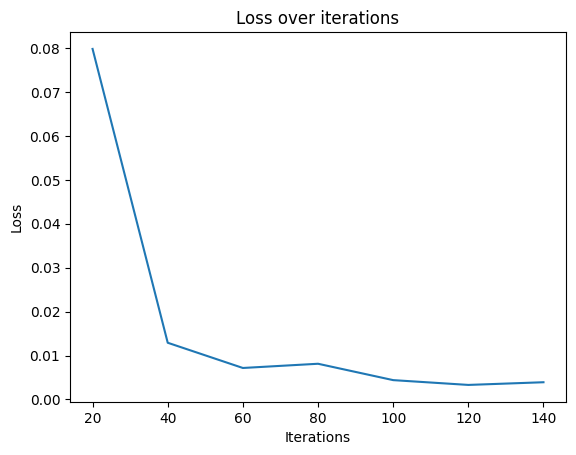

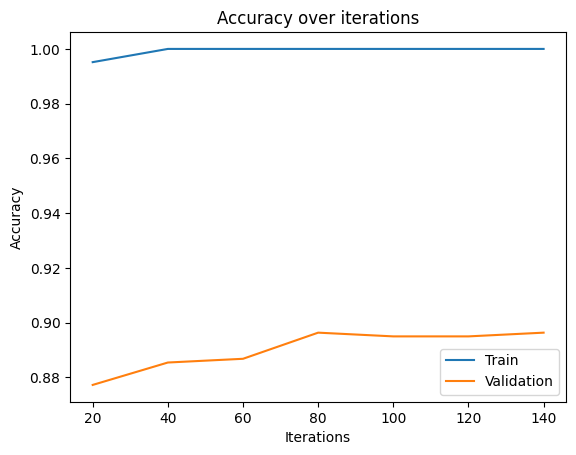

In [ ]:
m_linear = LinearModel()
train_model(m_linear, train_data_fets, valid_data_fets, num_epochs=50)

**Graded Task**: Compare this model with the CNN() models that we trained
earlier. How does this model perform in terms of validation accuracy?
What about in terms of the time it took to train this model?

In [ ]:
# This model performs very well, reaching 100% training accuracy nearly instant,
# and achieving a validation accuracy of about 90%. Note that even in the first
# few set of iterations, it still had an accuracy >88%, which suggests that it
# is much better at performing predictions than the CNN models we trained even
# with tremendously less training iterations. The computational power required
# was also much less, as this model took about 10 seconds to run and train
# fully, while each CNN with 50 epochs took about a good 5-10 minutes. This
# suggests that using strong pretrained networks to feature map the data
# beforehand to a lower dimensional and more usable set of data for a smaller
# neural network is likely much better than using a scratch NN which would not
# even come close in terms of its accuracy on general images even after fine
# tuning to this particular set of images. Note that the time it took for the
# AlexNet feature map of the data was sizably around 30 seconds to 1 minute, so
# even after combining the time of the linear network and AlexNet's map, it took
# less time overall.

**Task**:
We decide to use AlexNet features as input to our MLP, and avoided tuning AlexNet
weights. However, we could have considered AlexNet to be a part of our model, and
continue to tune AlexNet weights to improve our model performance. What are the
advantages and disadvantages of continuing to tune AlexNet weights?

In [ ]:
# The advantage is that we would be able to increase the predictive power even
# more as now the AlexNet itself can be finetuned to this particular problem.
# However, this could lead to extreme overfitting, which although would be fixed
# by possible double descent, would make it unusable for anything outside the
# hands similar to those in the data set. Moreover, the AlexNet is much larger
# and sophisticated than the linear model, and so the computational capacity
# to train it efficiently would be need to be larger and require more time.

## Part 4. Data

**Task**: Report the test accuracy on this transfer learning model.

In [ ]:
print(get_accuracy(m_linear, test_data_fets))

# The test accuracy is about 79%, which is still higher than the validation
# accuracy of the CNN. It is likely much lower than the validation and training
# as it is a much larger data set and is likely to hold more varied images.

0.7937219730941704


**Task**: Use this code below to construct the confusion matrix for this model
over the test set.

<Figure size 640x480 with 0 Axes>

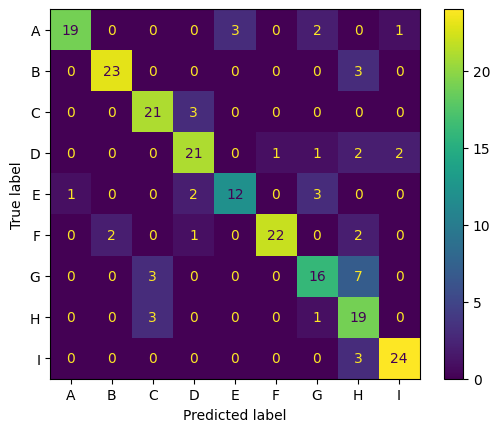

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sklearn
label = "ABCDEFGHI"
def plot_confusion(model, data):
    n = 0
    ts = []
    ys = []
    for x, t in data:
        z = model(x.unsqueeze(0))
        y = int(torch.argmax(z))
        ts.append(t)
        ys.append(y)

    cm = confusion_matrix(ts, ys)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
    plt.figure()
    disp.plot()

plot_confusion(m_linear, test_data_fets)

**Graded Task**: Which class is most likely mistaken as another?
Is this reasonable? (i.e. is that class particularly challenging, or
very similar to another class?)

In [ ]:
# The class that is mistaken as an outlier out of the others (off-diagonal) is
# the letter G as the letter H. In sign language, both are given by a pointing
# hand in the left direction, the difference being G has one finger and H has
# two fingers. They look very similar without the hindsight or capacity to
# fully distinguish fingers in an image, so it is reasonable to mistake one for
# the other. The interesting detail is that only G is being mistaken for H, not
# the other way around, so it seems to be asymmetric, likely due to the double
# finger being distinguishable from a single finger if you start with it, but
# maybe the model sees a single finger as a possible double finger, so it is
# not transitive.

**Task**: In order to understand where errors come from, it is *crucial* that
we explore why and how our models fail. A first step is to visually inspect the
test data points where failure occurs. That way, we can identify what we can do
to prevent/fix errors before our models are deployed.

Run the below code to display images in the test set that our model *misclassifies*:

<ipython-input-38-949329e55583>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


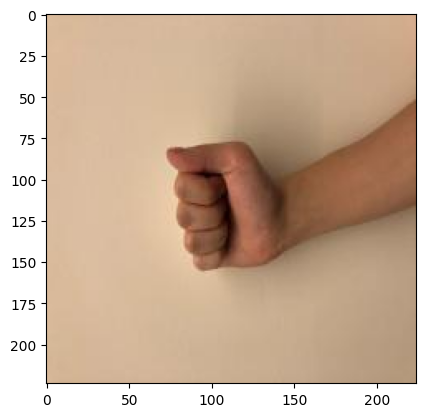

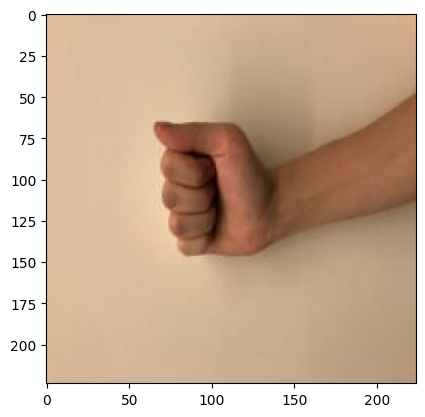

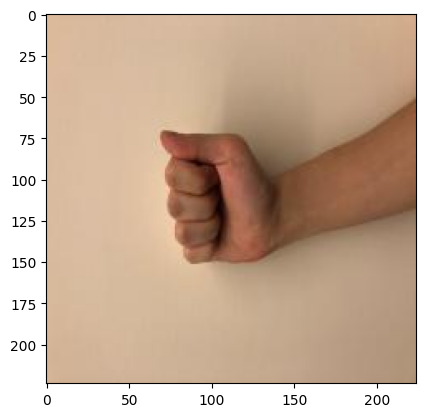

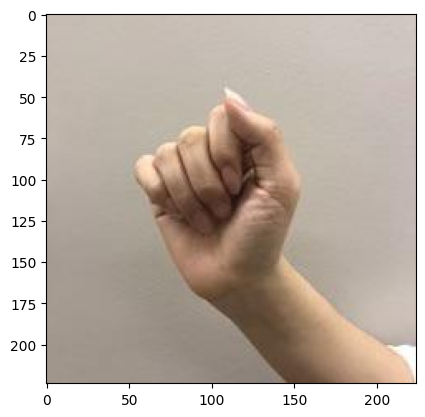

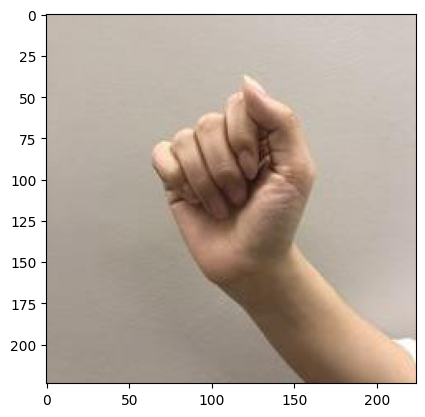

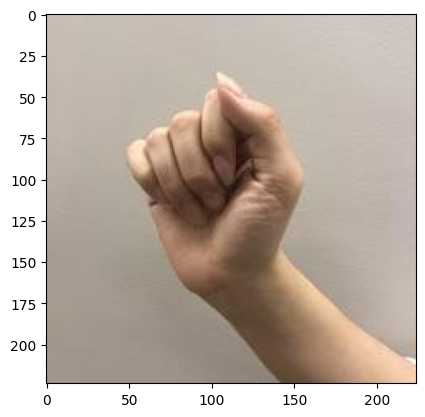

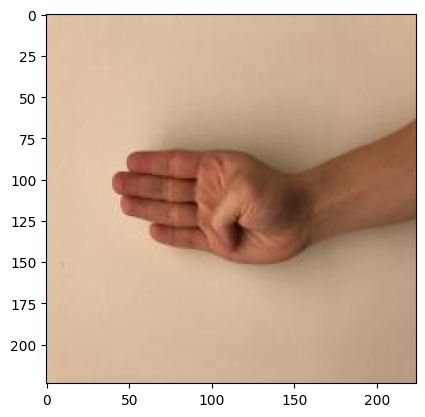

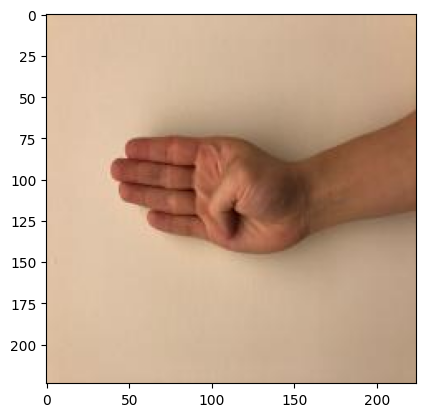

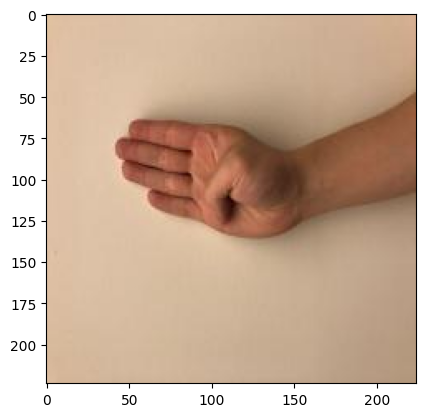

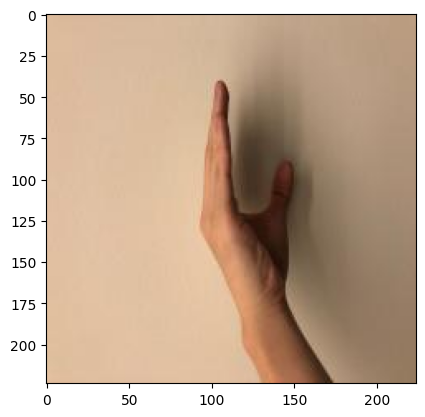

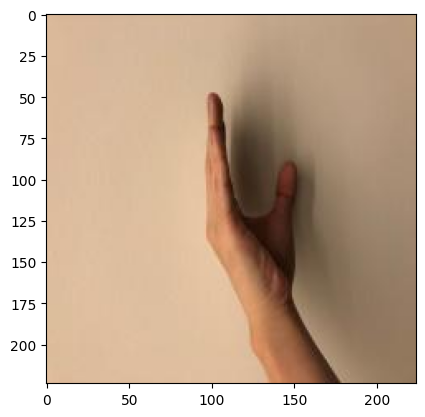

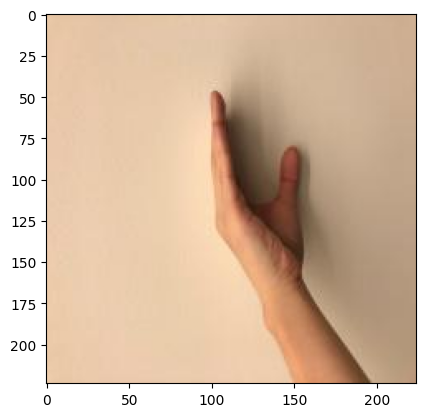

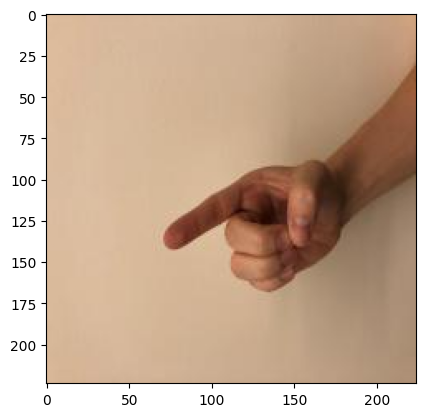

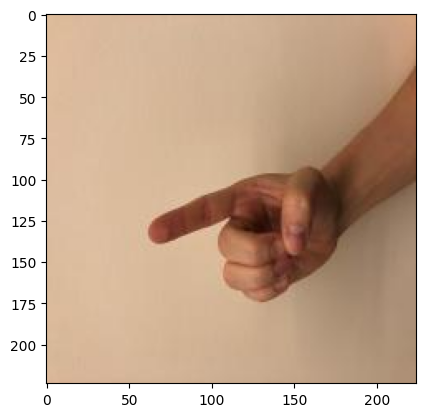

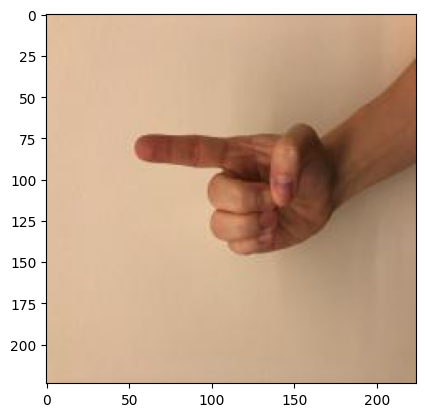

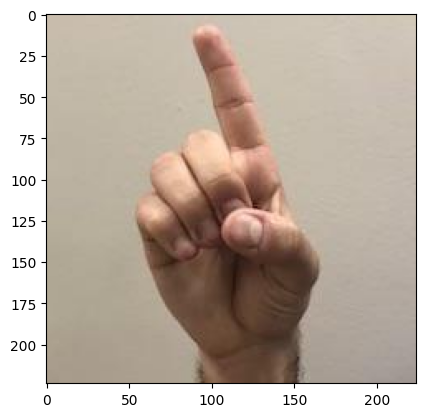

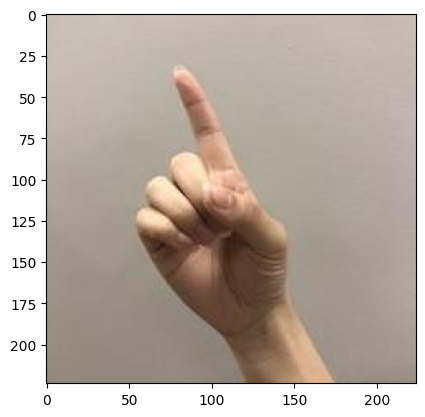

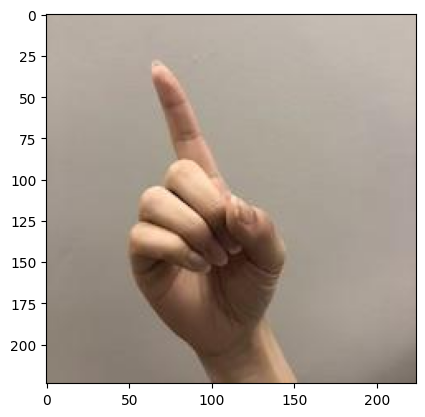

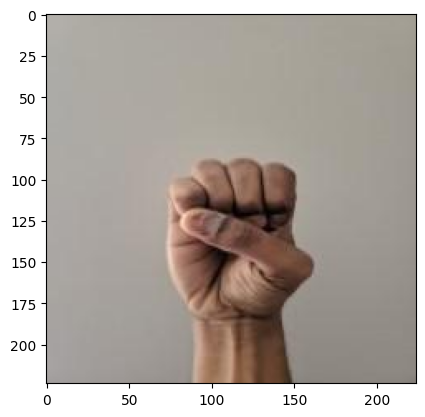

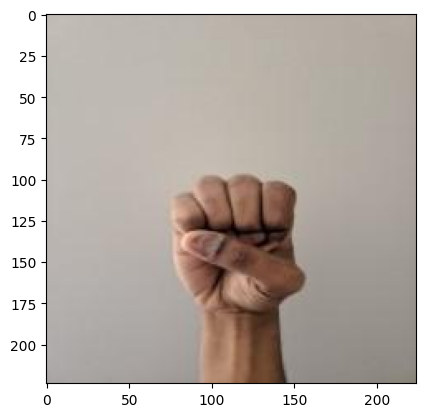

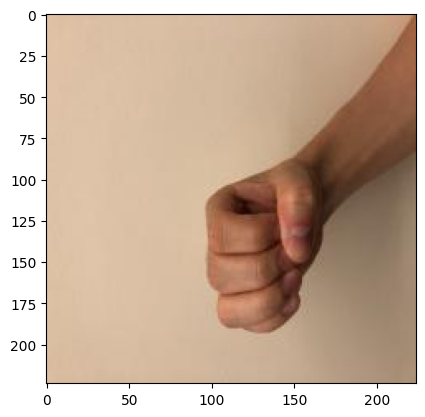

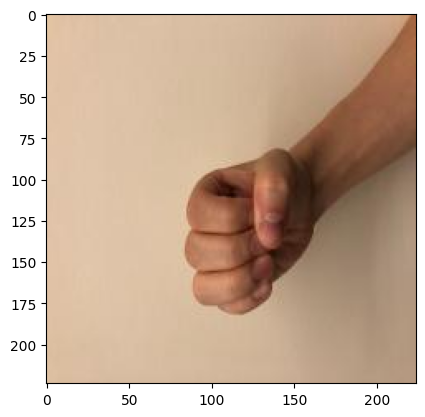

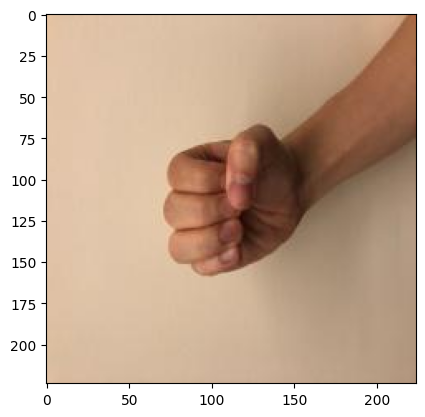

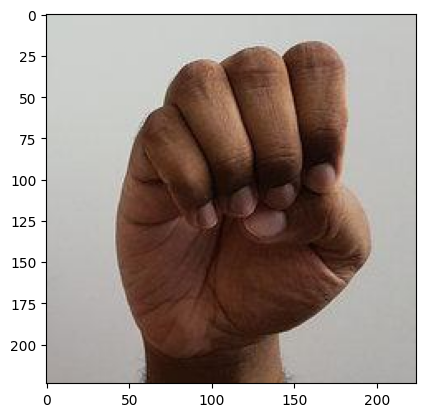

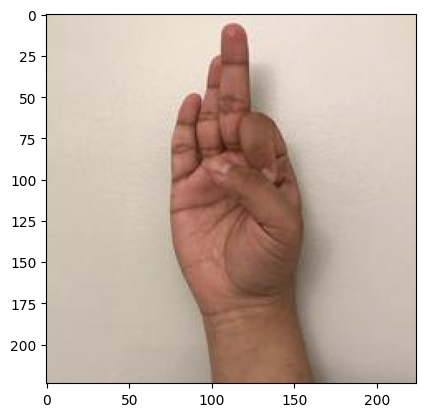

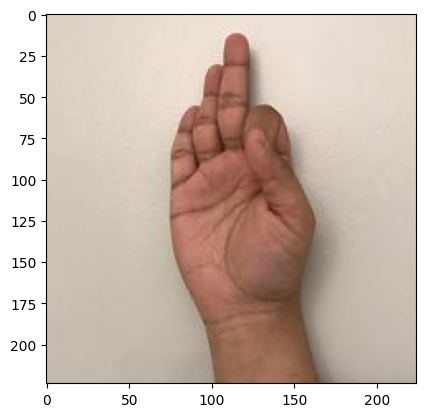

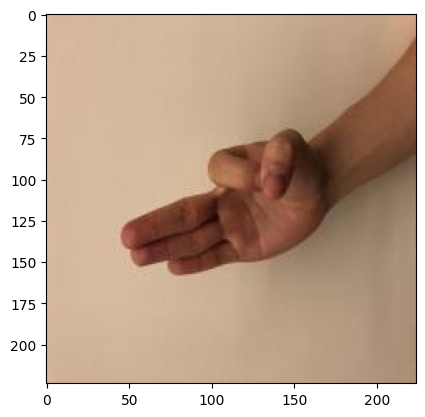

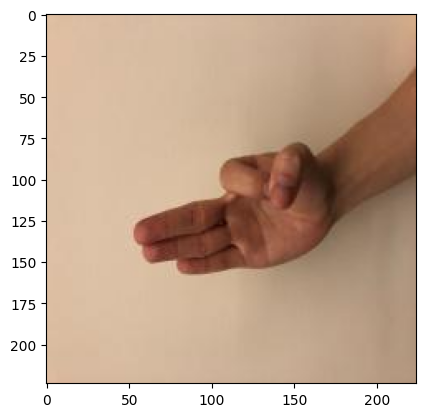

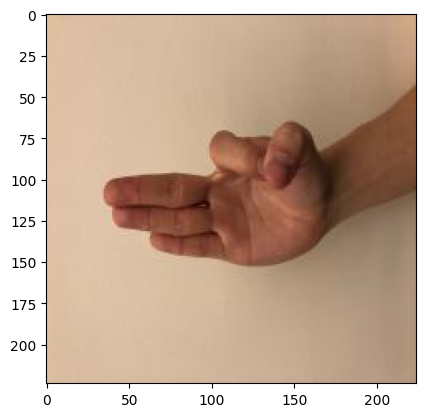

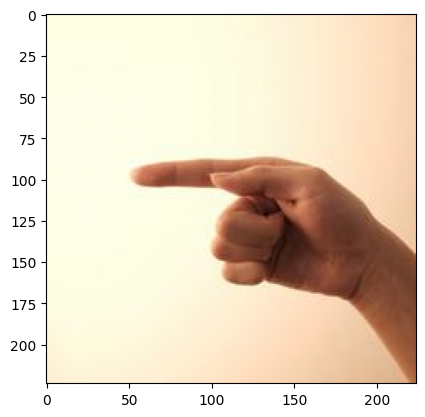

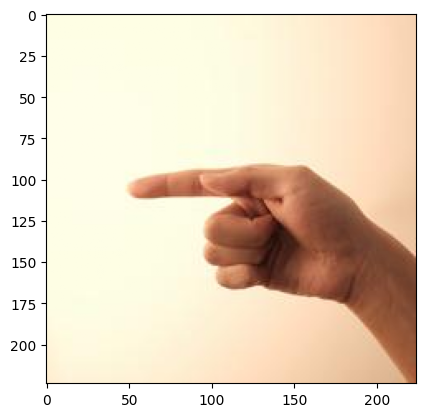

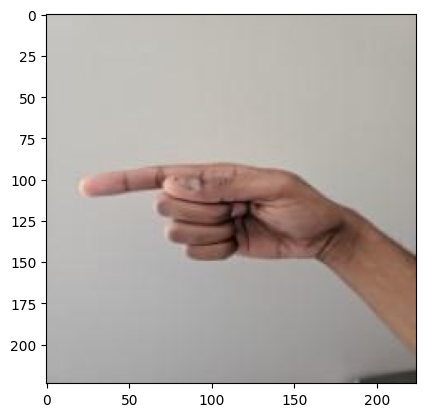

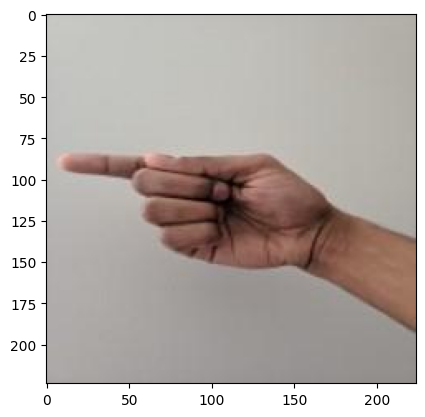

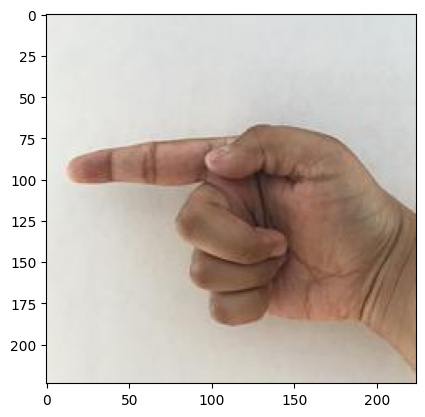

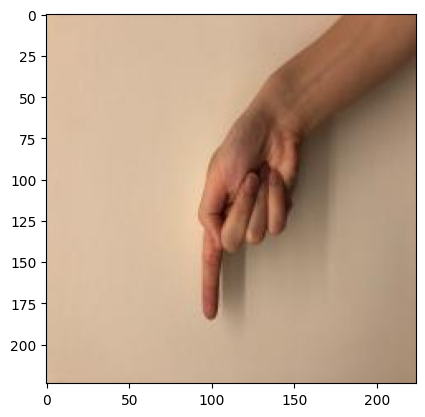

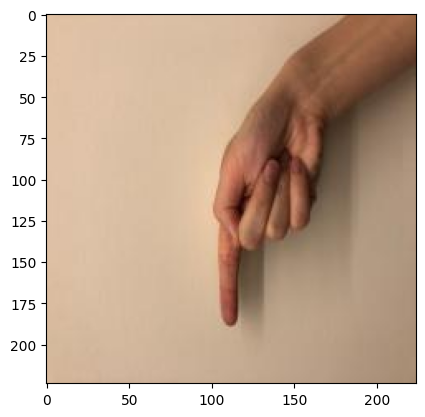

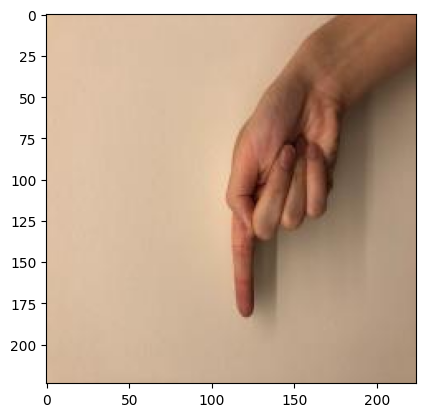

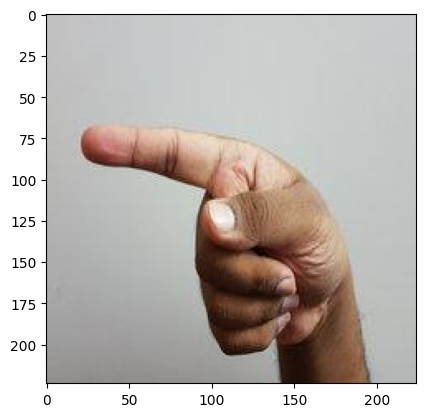

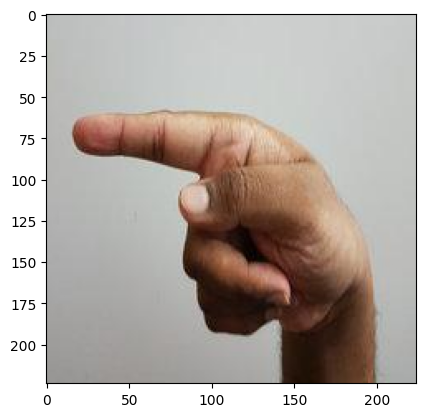

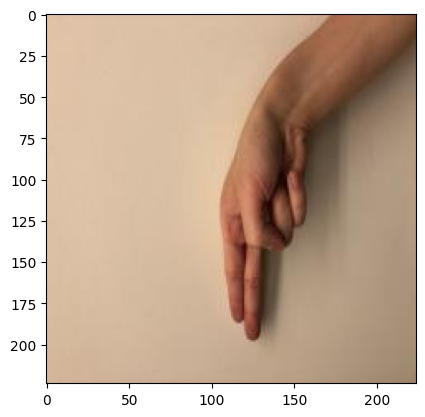

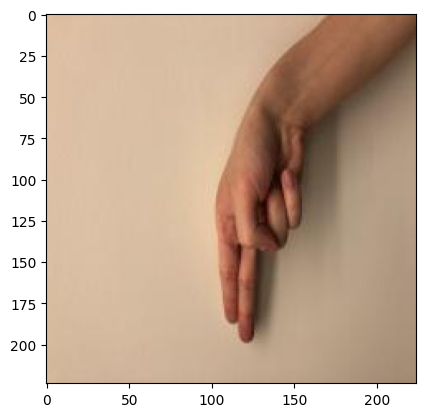

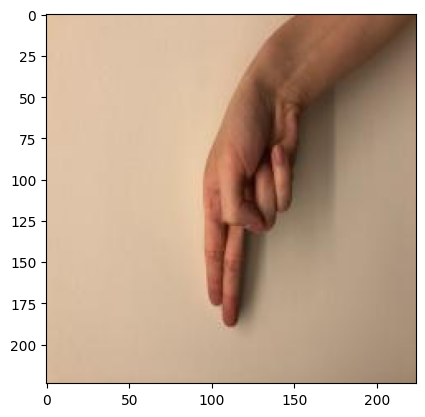

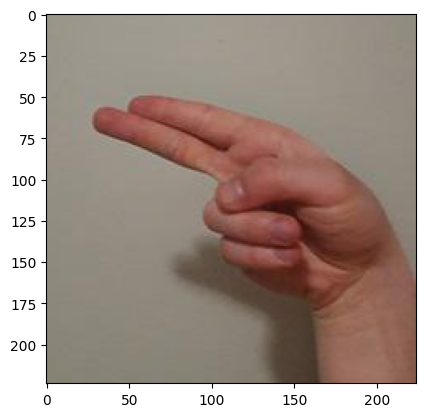

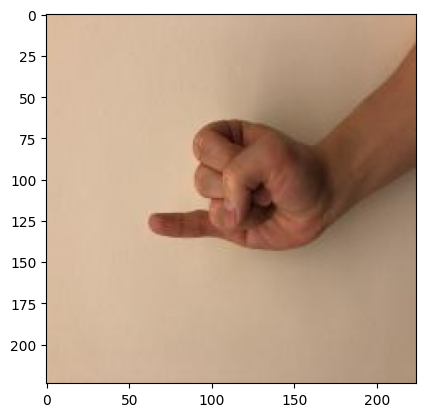

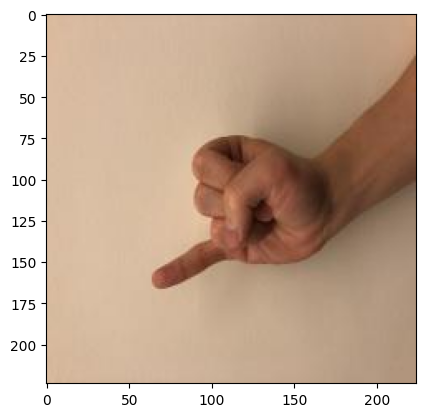

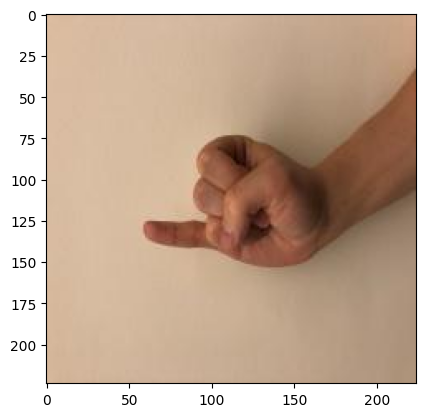

In [ ]:
for i, (x, t) in enumerate(test_data_fets):
    y = int(torch.argmax(m_linear(x)))
    if not (y == t):
        plt.figure()
        plt.imshow(test_data[i][0].transpose(0,1).transpose(1,2).numpy())

**Task**: By visually inspecting these misclassified images, we see that there are
two main reasons for misclassification. What reason for misclassification is
due to a mistake in the formatting of the test set images?

In [ ]:
# One of the reasons is that some images seem to be rotated from the position
# in which one would normally view them in ASL conversation, and as a linear
# model is not necessarily invariant under rotations, it could maybe misclassify
# the feature map of AlexNet more in these cases. The background also has a
# different colour in each example, and the perspective is slightly different in
# each case, which could lead to errors.

**Graded Task**: We also see a much more serious issue, where gestures made by
individuals with darker skin tones may be more frequently misclasified.
This result suggests that errors in the model may impact some groups more than
others. What steps should we take to mitigate this issue?

In [ ]:
# Maybe by increasing the representation of more varied types of hands in the
# data--for example, of various skin colours and tones, and shapes and textures
# --the model would not overfit to a particular type of hand in the training set
# and likely better classify all types of hands. This particularly means also
# making sure that the train-test-valid split keeps a fair distribution of each
# hand type in each one. Ensuring that the data is also high quality, as in it
# is taken with good equipment that ensures that the actual input information is
# not poisoned with something like low resolution or static or something else is
# necessary to ensure that it performs good predictions. Or alternatively,
# introducing photos like that to train on could help adjust or control for the
# possibility of images that aren't as well-taken and would normally lead to
# misclassification if they weren't taken into account.